In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

In [5]:
data = pd.read_csv("C:\\Users\\Shivu\\Desktop\\ISB\mnist\\train.csv")
data1 = pd.read_csv("C:\\Users\\Shivu\\Desktop\\ISB\mnist\\test.csv")

In [6]:
data1.shape

(28000, 784)

In [7]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [8]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


In [9]:
images1 = data1.values
images1 = images1.astype(np.float)
image_size1 = data1.shape[1]
print ('image_size1 => {0}'.format(image_size))

# in this case all images are square
image_width1 = image_height1 = np.ceil(np.sqrt(image_size1)).astype(np.uint8)

print ('image_width1 => {0}\nimage_height1 => {1}'.format(image_width1,image_height1))

image_size1 => 784
image_width1 => 28
image_height1 => 28


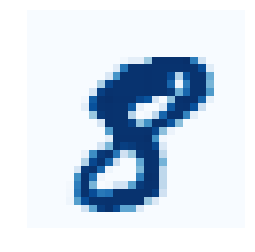

In [16]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.Blues)

# output image     
display(images[10])

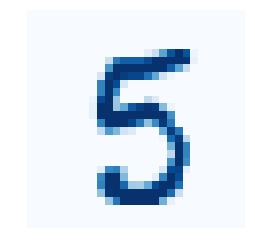

In [15]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width1,image_height1)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.Blues)

# output image     
display(images1[10])

In [17]:
####There is no test label
labels_flat = data.iloc[:,0].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
print (labels_flat)
print (labels_count)

[1 0 1 ..., 7 6 9]
10


In [18]:
labels_flat1 = data1.iloc[:,0].values.ravel()
labels_count1 = np.unique(labels_flat1).shape[0]
print (labels_flat1)
print (labels_count1)

[0 0 0 ..., 0 0 0]
1


In [21]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(10,labels[10]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


Deep Learning on MNIST data

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [39]:
# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 1000
display_step = 1

In [32]:
def inference(x):
    init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", [784, 10],
                         initializer=init)
    b = tf.get_variable("b", [10],
                         initializer=init)
    output = tf.nn.softmax(tf.matmul(x, W) + b)

    w_hist = tf.summary.histogram("weights", W)
    b_hist = tf.summary.histogram("biases", b)
    y_hist = tf.summary.histogram("output", output)

    return output

In [33]:
def loss(output, y):   
    loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(output), axis=1))
    return loss

In [34]:
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)

    return train_op

In [35]:
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.summary.scalar("validation error", (1.0 - accuracy))

    return accuracy

In [36]:
with tf.Graph().as_default():

        x = tf.placeholder("float", [None, 784]) # mnist data image of shape 28*28=784
        y = tf.placeholder("float", [None, 10]) # 0-9 digits recognition => 10 classes


        output = inference(x)

        cost = loss(output, y)

        global_step = tf.Variable(0, name='global_step', trainable=False)

        train_op = training(cost, global_step)

        eval_op = evaluate(output, y)

        summary_op = tf.summary.merge_all()

        saver = tf.train.Saver()

        sess = tf.Session()

        summary_writer = tf.summary.FileWriter("logistic_logs/",
                                            graph_def=sess.graph_def)

        
        init_op = tf.global_variables_initializer()

        sess.run(init_op)
        

INFO:tensorflow:Summary name validation error is illegal; using validation_error instead.


In [40]:
 # Training cycle
for epoch in range(training_epochs):

            avg_cost = 0.
            total_batch = int(40000/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
                # Fit training using batch data
                sess.run(train_op, feed_dict={x: minibatch_x, y: minibatch_y})
                # Compute average loss
                avg_cost += sess.run(cost, feed_dict={x: minibatch_x, y: minibatch_y})/total_batch
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

                accuracy = sess.run(eval_op, feed_dict={x: mnist.validation.images, y: mnist.validation.labels})

                print("Validation Error:", (1 - accuracy))
               
                

                summary_str = sess.run(summary_op, feed_dict={x: minibatch_x, y: minibatch_y})
                summary_writer.add_summary(summary_str, sess.run(global_step))

                saver.save(sess, "logistic_logs/model-checkpoint", global_step=global_step)


print("Optimization Finished!")


accuracy = sess.run(eval_op, feed_dict={x: mnist.test.images, y: mnist.test.labels})

print("Test Accuracy:", accuracy)

Epoch: 0001 cost = 0.658538747
Validation Error: 0.136799991131
Epoch: 0002 cost = 0.644950986
Validation Error: 0.135800004005
Epoch: 0003 cost = 0.636945637
Validation Error: 0.134400010109
Epoch: 0004 cost = 0.625954048
Validation Error: 0.132799983025
Epoch: 0005 cost = 0.616062401
Validation Error: 0.131399989128
Epoch: 0006 cost = 0.607994707
Validation Error: 0.130999982357
Epoch: 0007 cost = 0.597444797
Validation Error: 0.129599988461
Epoch: 0008 cost = 0.592901430
Validation Error: 0.129400014877
Epoch: 0009 cost = 0.586489531
Validation Error: 0.12760001421
Epoch: 0010 cost = 0.577328564
Validation Error: 0.126600027084
Epoch: 0011 cost = 0.575177935
Validation Error: 0.125800013542
Epoch: 0012 cost = 0.562760326
Validation Error: 0.125599980354
Epoch: 0013 cost = 0.561457309
Validation Error: 0.124199986458
Epoch: 0014 cost = 0.552553233
Validation Error: 0.124000012875
Epoch: 0015 cost = 0.549544871
Validation Error: 0.123399972916
Epoch: 0016 cost = 0.542220132
Validation